In [1]:
import prior

dataset = prior.load_dataset("procthor-10k")
dataset

[AI2-THOR WARNING] There has been an update to ProcTHOR-10K that must be used with AI2-THOR version 5.0+. To use the new version of ProcTHOR-10K, please update AI2-THOR to version 5.0+ by running:
    pip install --upgrade ai2thor
Alternatively, to downgrade to the old version of ProcTHOR-10K, run:
   prior.load_dataset("procthor-10k", revision="ab3cacd0fc17754d4c080a3fd50b18395fae8647")


Loading test: 100%|██████████| 1000/1000 [00:00<00:00, 12059.60it/s]


DatasetDict(
    train=Dataset(
    dataset=procthor-dataset,
    size=10000,
    split=train
),
    val=Dataset(
    dataset=procthor-dataset,
    size=1000,
    split=val
),
    test=Dataset(
    dataset=procthor-dataset,
    size=1000,
    split=test
)
)

In [2]:
from ai2thor.controller import Controller


house = dataset["train"][3]
controller = Controller(scene=house, snapToGrid=False, rotateStepDegrees=30)
event = controller.step("Pass")
spawn = event.metadata["agent"]["position"]

/home/juyuanli/miniconda3/envs/nav_assistant/lib/python3.11/site-packages/ai2thor/platform.py:154: UserWarning: could not connect to X Display: 5, Can't connect to display ":5": b'Authorization required, but no authorization protocol specified\n'
  warnings.warn(


In [3]:
import torch
from torch import nn
import matplotlib.pyplot as plt
from rl import RNDIntrinsicReward
import numpy as np

# RND Trial (Can be skipped)

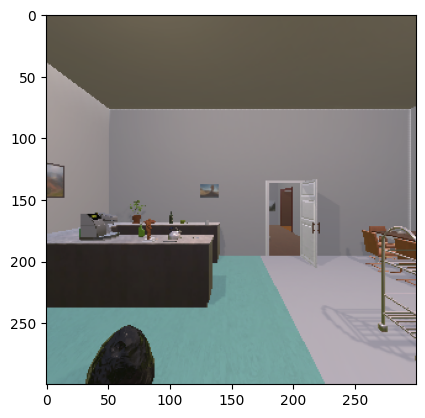

In [4]:
rnd_try = RNDIntrinsicReward()
event = controller.step(
    action="TeleportFull",
    x=spawn["x"],
    y=spawn["y"],
    z=spawn["z"],
    rotation={"x": 0, "y": 90, "z": 0},
    horizon=0,
    standing=True
)
plt.imshow(event.frame)

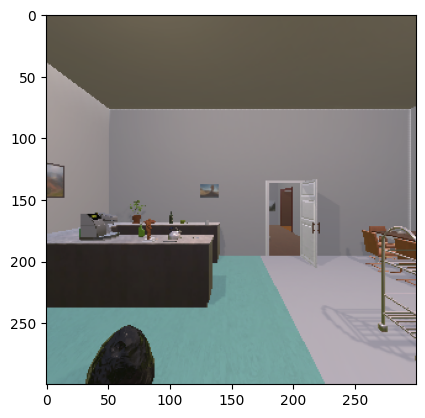

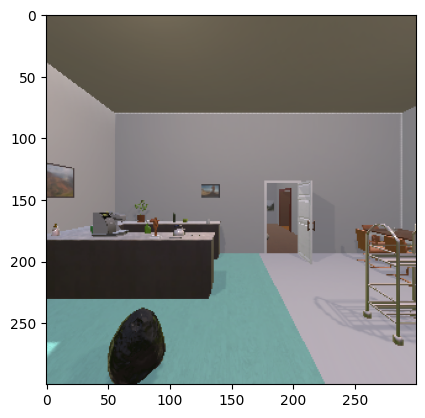

[0.6022416548479056, 0.5854337095586398, 0.5707490719054661, 0.5568277886396936, 0.5440669863510298] 0.5504761112339458


In [5]:
event = controller.step("Pass")

rws = []
for i in range(5):
    rw1 = rnd_try.compute_reward(rnd_try.pre_process_rnd(event))
    rws.append(rw1)
plt.imshow(event.frame)
plt.show()
event = controller.step("MoveBack")
plt.imshow(event.frame)
plt.show()
rw3 = rnd_try.compute_reward(rnd_try.pre_process_rnd(event))
print(rws, rw3)
# plt.imshow(event.frame.copy())

# Start Training

In [4]:
def teleport(controller, target=None):
    event = controller.step("GetReachablePositions")
    reachable_positions = event.metadata["actionReturn"]
    # Pick a random target
    if target is None:
        target = np.random.choice(reachable_positions)

    event = controller.step(
        action="TeleportFull",
        x=target["x"],
        y=target["y"],
        z=target["z"],
        rotation={"x": 0, "y": 0, "z": 0},
        horizon=0,
        standing=True
    )

    return event


In [5]:
from rl import PPO, ActorCritic, Env, RolloutBuffer, RNDIntrinsicEnv, ClipEnv, CLIPNovelty
from models import Actor, Critic, FrozenResNetEncoder
from cons import MINIBATCHES, EPISODE_STEPS, FEAT_DIM, NUM_ACTIONS, DEVICE

In [6]:
from rl import save_actor_critic

def train(controller, name: str, ppo: PPO, env: Env, actor_critic: ActorCritic, total_updates=10):
    event = controller.step("Pass")  # prime
    rewards = []
    episode_rewards = []
    for upd in range(total_updates):
        buf = RolloutBuffer()
        for mb in range(MINIBATCHES):
            # collect episodes
            episode_seq = []
            episode_reward = 0
            actions_seq = []
            for t in range(1, EPISODE_STEPS + 1):
                obs_t = ppo.obs_from_event(event)  # (C,H,W)
                obs_seq = torch.stack(episode_seq + [obs_t], dim=0).unsqueeze(0).to(device=DEVICE)

                if len(actions_seq) == 0:
                    actions_seq.append(torch.randint(0, NUM_ACTIONS, (1, 1)).item())
                
                actions_tensor = torch.tensor(actions_seq, dtype=torch.long, device=DEVICE).unsqueeze(0)
                logits, value = ppo.act_and_value(obs_seq, actions_tensor, actor_critic)
                dist = torch.distributions.Categorical(logits=logits)
                action_idx = dist.sample()
                logp = dist.log_prob(action_idx)
                
                action_idx, logp = action_idx.item(), logp.item()
                event, reward = env.step_env(controller, action_idx)
                done = t == EPISODE_STEPS

                # store one step
                buf.add(obs_t, action_idx, logp, reward, value, done)
                episode_seq.append(obs_t)
                rewards.append(reward)
                actions_seq.append(action_idx)
                
                episode_reward += reward / EPISODE_STEPS

                # 50% chance of teleport
                if done and np.random.rand() > 0.5:
                    event = teleport(controller)
                    env.reset()
            episode_rewards.append(episode_reward)
                
        ppo.ppo_update(buf, actor_critic)
        save_actor_critic(actor_critic, name)
        
        print(f"Update {upd+1}/{total_updates} — steps: {len(buf)}")
        plt.plot(rewards)
        plt.show()
        plt.plot(episode_rewards)
        plt.show()
    return buf, rewards

In [7]:
rnd_reward = RNDIntrinsicReward()
rnd_intrinsic_env = RNDIntrinsicEnv(rnd_reward)
rnd_actor_critic = ActorCritic()
ppo = PPO(0.08)
buf, rewards = train(controller, "clip_actor_critic_checkpoint_lstm.pt", ppo, rnd_intrinsic_env, rnd_actor_critic, 1)

TypeError: ActorCritic.__init__() missing 3 required positional arguments: 'encoder', 'actor', and 'critic'

# Final Inference

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from cons import ACTIONS

n = 120
n_row = 8
positions = []

plt.figure(figsize=(n // n_row, n_row))
event = teleport(controller)

episode_seq = []
for t in range(1, n + 1):
    obs_t = ppo.obs_from_event(event)  # (C,H,W)
    obs_seq = torch.stack(episode_seq + [obs_t], dim=0).unsqueeze(0)
    logits, value = ppo.act_and_value(obs_seq)
    dist = torch.distributions.Categorical(logits=logits)
    print(logits.shape)
    print(torch.softmax(logits, dim=0))
    action_idx = dist.sample()
    # action_idx = np.random.randint(0, 4)

    event, reward = rnd_intrinsic_env.step_env(controller, action_idx)
    done = t == EPISODE_STEPS

    # Extract agent position from metadata
    pos = event.metadata["agent"]["position"]
    positions.append((pos["x"], pos["z"]))  # store x,z

    # Plot frame and action
    plt.subplot(n_row, n // n_row, t)
    plt.title("action: " + ACTIONS[action_idx] + ", r: " + f"{reward:.2f}", fontsize=5)
    plt.axis(False)
    plt.imshow(event.frame)

plt.tight_layout()
plt.show()

# ---- Plot 2D trajectory of the agent ----
positions = np.array(positions)
plt.figure(figsize=(4, 4))
plt.plot(positions[:, 0], positions[:, 1], "-o", markersize=3)
plt.xlabel("x")
plt.ylabel("z")
plt.title("Agent trajectory over n steps")
plt.grid(True)
plt.show()


TypeError: act_and_value() missing 1 required positional argument: 'actor_critic'

<Figure size 1500x800 with 0 Axes>

In [18]:
controller.stop()

# CLIP Novelty - Transformer

In [7]:
ENTROPY_COEF = 0.02

ppo = PPO(ENTROPY_COEF)
encoder = FrozenResNetEncoder()
actor = Actor(FEAT_DIM, NUM_ACTIONS, n_layers=4)
critic = Critic(FEAT_DIM, n_layers=4)
clip_novelty = CLIPNovelty()
clip_env = ClipEnv(clip_novelty)
clip_actor_critic = ActorCritic(encoder, actor, critic)


In [9]:
from rl import load_actor_critic

load_actor_critic(clip_actor_critic,  "clip_actor_critic_checkpoint_smooth_topk.pt")

[🔁] Actor-Critic checkpoint loaded from clip_actor_critic_checkpoint_smooth_topk.pt


[PPO] Epoch 0: Loss=11.4375, Policy=0.0080, Value=22.8985
[PPO] Epoch 10: Loss=5.5231, Policy=0.0010, Value=11.0828
[PPO] Epoch 20: Loss=4.1777, Policy=-0.0074, Value=8.4096
[PPO] Epoch 30: Loss=3.0186, Policy=-0.0139, Value=6.1032
[PPO] Epoch 40: Loss=2.2466, Policy=-0.0243, Value=4.5804
Approx KL Learned: 0.018360313028097153
[✅] Actor-Critic checkpoint saved to clip_actor_critic_checkpoint_smooth_topk.pt
Update 1/10 — steps: 1024


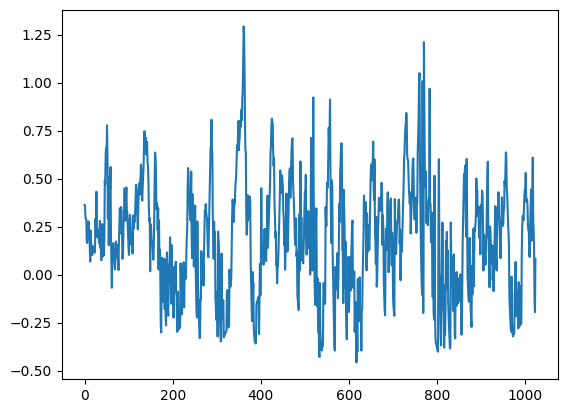

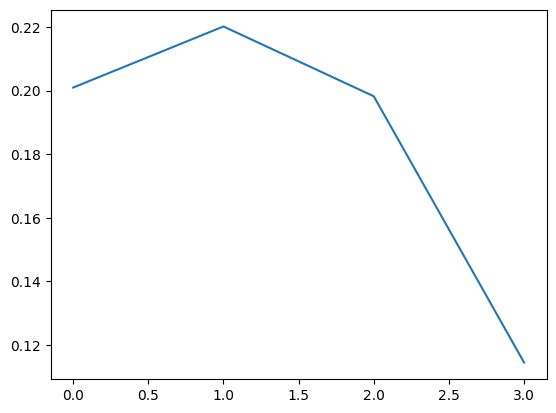

[PPO] Epoch 0: Loss=8.3488, Policy=0.0036, Value=16.7300
[PPO] Epoch 10: Loss=3.9033, Policy=-0.0080, Value=7.8614
[PPO] Epoch 20: Loss=3.0882, Policy=-0.0039, Value=6.2233
[PPO] Epoch 30: Loss=2.3274, Policy=0.0231, Value=4.6419
[PPO] Epoch 40: Loss=1.5980, Policy=-0.0088, Value=3.2540
Approx KL Learned: 0.01139512937515974
[✅] Actor-Critic checkpoint saved to clip_actor_critic_checkpoint_smooth_topk.pt
Update 2/10 — steps: 1024


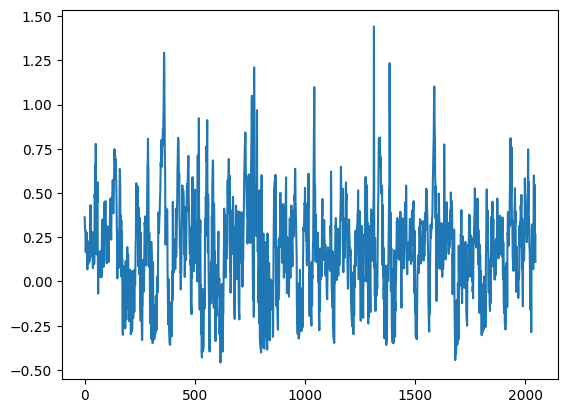

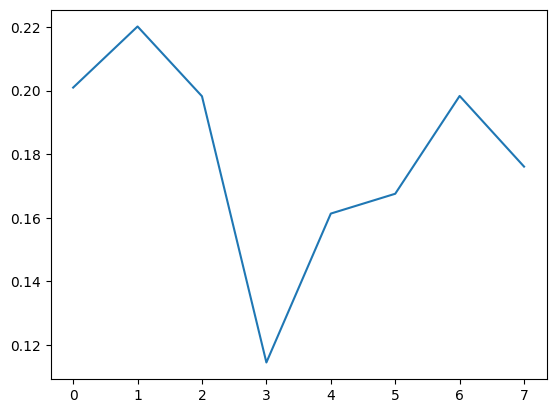

[PPO] Epoch 0: Loss=6.5009, Policy=0.0007, Value=13.0395
[PPO] Epoch 10: Loss=4.0293, Policy=-0.0001, Value=8.0971
[PPO] Epoch 20: Loss=2.7239, Policy=-0.0126, Value=5.5118
[PPO] Epoch 30: Loss=1.9651, Policy=-0.0195, Value=4.0078
[PPO] Epoch 40: Loss=1.3243, Policy=-0.0273, Value=2.7413
Approx KL Learned: 0.02724362723529339
[✅] Actor-Critic checkpoint saved to clip_actor_critic_checkpoint_smooth_topk.pt
Update 3/10 — steps: 1024


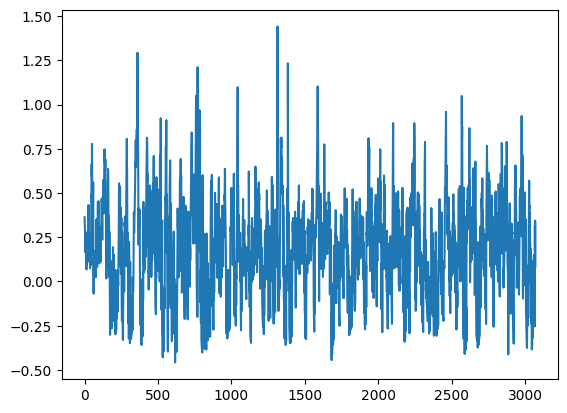

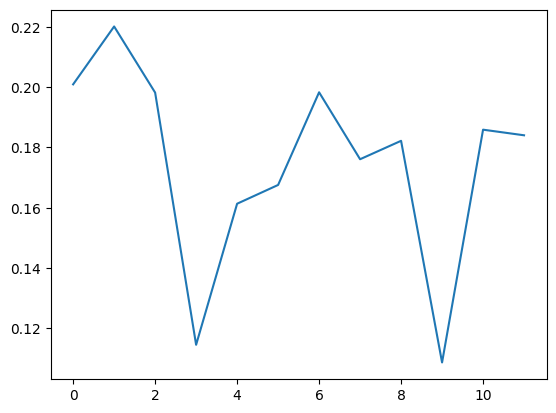

[PPO] Epoch 0: Loss=12.9240, Policy=0.0094, Value=25.8655
[PPO] Epoch 10: Loss=9.8582, Policy=0.0029, Value=19.7480
[PPO] Epoch 20: Loss=8.2300, Policy=-0.0038, Value=16.5044
[PPO] Epoch 30: Loss=6.8733, Policy=-0.0116, Value=13.8069
[PPO] Epoch 40: Loss=5.4945, Policy=-0.0172, Value=11.0604
Approx KL Learned: 0.008466917090117931
[✅] Actor-Critic checkpoint saved to clip_actor_critic_checkpoint_smooth_topk.pt
Update 4/10 — steps: 1024


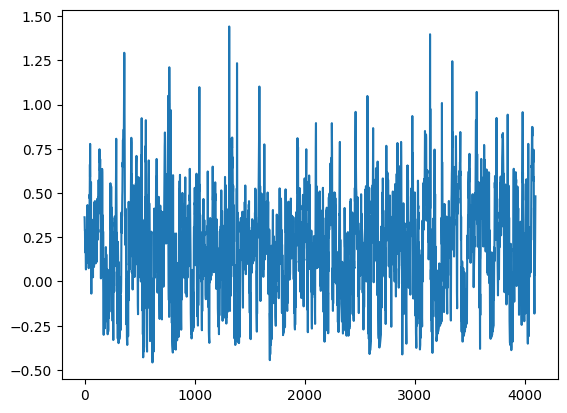

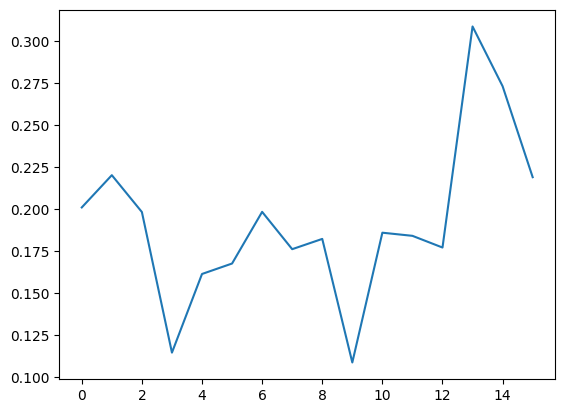

[PPO] Epoch 0: Loss=10.8982, Policy=0.0031, Value=21.8265
[PPO] Epoch 10: Loss=8.2450, Policy=-0.0008, Value=16.5291
[PPO] Epoch 20: Loss=6.7975, Policy=-0.0118, Value=13.6559
[PPO] Epoch 30: Loss=5.6370, Policy=-0.0205, Value=11.3517
[PPO] Epoch 40: Loss=4.2589, Policy=-0.0347, Value=8.6236
Approx KL Learned: 0.02127477340400219
[✅] Actor-Critic checkpoint saved to clip_actor_critic_checkpoint_smooth_topk.pt
Update 5/10 — steps: 1024


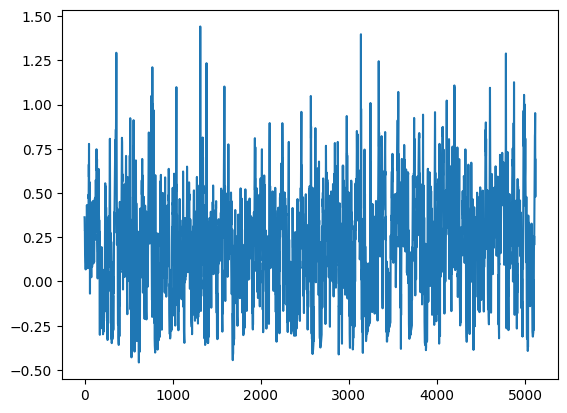

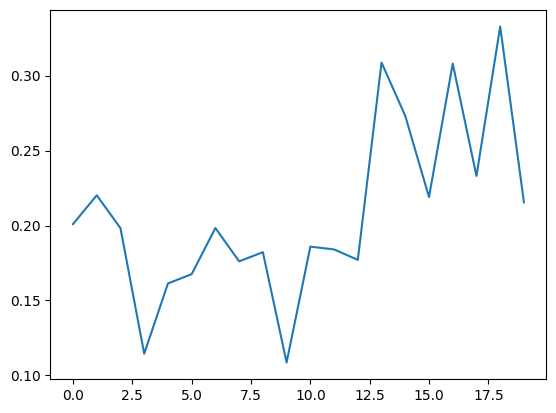

[PPO] Epoch 0: Loss=5.5285, Policy=0.0077, Value=11.0784
[PPO] Epoch 10: Loss=3.0907, Policy=0.0030, Value=6.2116
[PPO] Epoch 20: Loss=1.8948, Policy=-0.0064, Value=3.8392
[PPO] Epoch 30: Loss=1.1925, Policy=-0.0188, Value=2.4593
[PPO] Epoch 40: Loss=1.6081, Policy=-0.0085, Value=3.2700
Approx KL Learned: 0.016534391790628433
[✅] Actor-Critic checkpoint saved to clip_actor_critic_checkpoint_smooth_topk.pt
Update 6/10 — steps: 1024


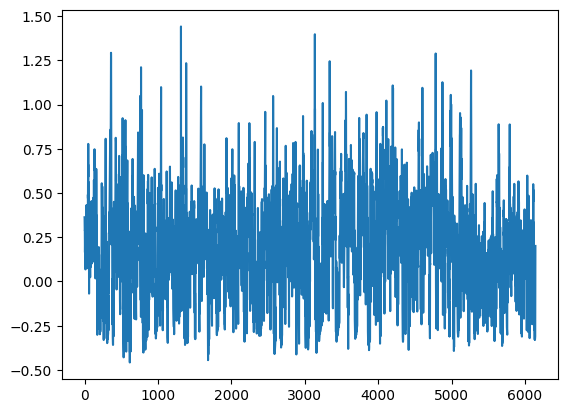

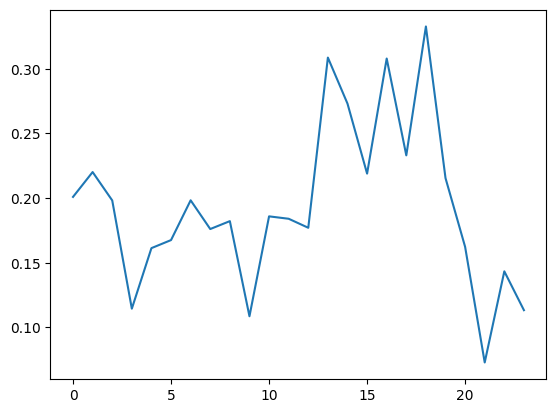

[PPO] Epoch 0: Loss=7.3610, Policy=0.0021, Value=14.7549
[PPO] Epoch 10: Loss=4.1909, Policy=0.0026, Value=8.4142
[PPO] Epoch 20: Loss=2.5047, Policy=-0.0113, Value=5.0694
[PPO] Epoch 30: Loss=1.2500, Policy=-0.0187, Value=2.5745
[PPO] Epoch 40: Loss=0.7498, Policy=-0.0385, Value=1.6133
Approx KL Learned: 0.035278961062431335
[✅] Actor-Critic checkpoint saved to clip_actor_critic_checkpoint_smooth_topk.pt
Update 7/10 — steps: 1024


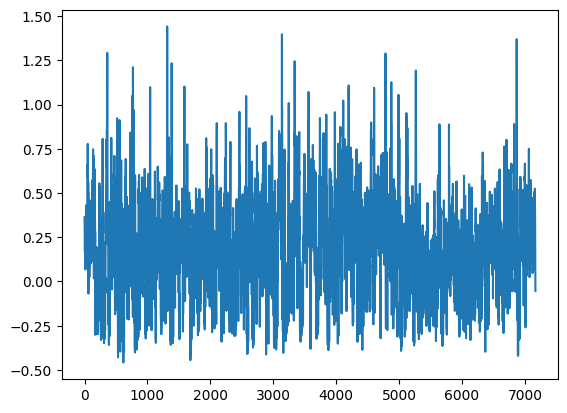

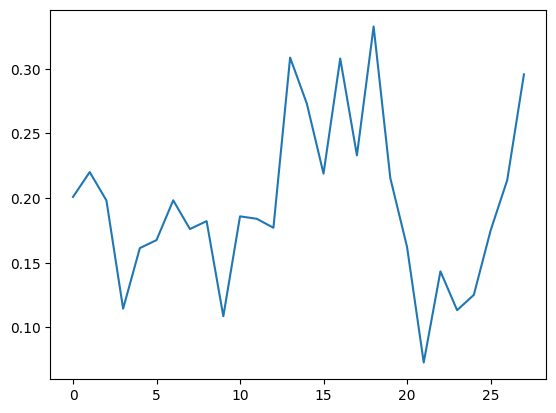

[PPO] Epoch 0: Loss=15.0075, Policy=-0.0014, Value=30.0501
[PPO] Epoch 10: Loss=10.1192, Policy=-0.0116, Value=20.2924
[PPO] Epoch 20: Loss=6.8010, Policy=-0.0298, Value=13.6930
[PPO] Epoch 30: Loss=5.3077, Policy=-0.0337, Value=10.7155
[PPO] Epoch 40: Loss=4.4995, Policy=-0.0561, Value=9.1428
Approx KL Learned: 0.04184185713529587
[✅] Actor-Critic checkpoint saved to clip_actor_critic_checkpoint_smooth_topk.pt
Update 8/10 — steps: 1024


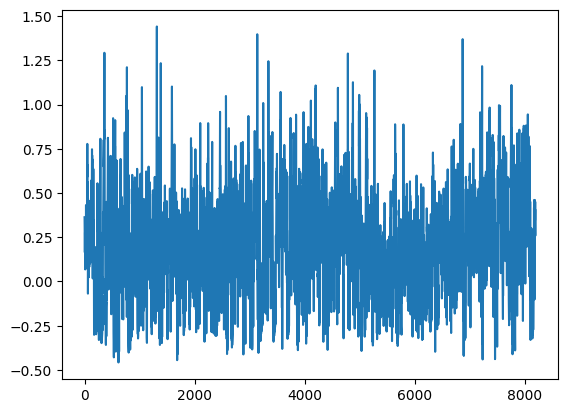

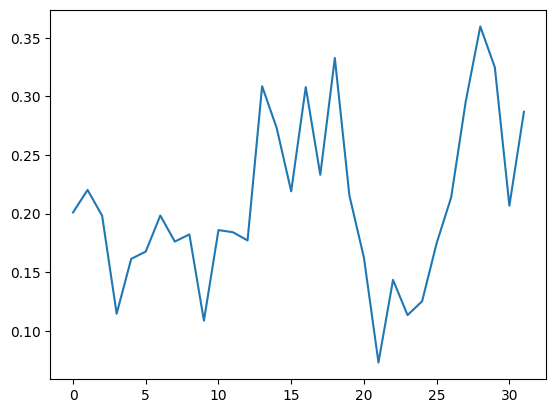

[PPO] Epoch 0: Loss=12.5886, Policy=0.0088, Value=25.1958
[PPO] Epoch 10: Loss=8.5526, Policy=-0.0039, Value=17.1488
[PPO] Epoch 20: Loss=7.7645, Policy=-0.0244, Value=15.6137
[PPO] Epoch 30: Loss=7.4285, Policy=-0.0375, Value=14.9672
[PPO] Epoch 40: Loss=7.7607, Policy=-0.0417, Value=15.6399
Approx KL Learned: 0.03632374852895737
[✅] Actor-Critic checkpoint saved to clip_actor_critic_checkpoint_smooth_topk.pt
Update 9/10 — steps: 1024


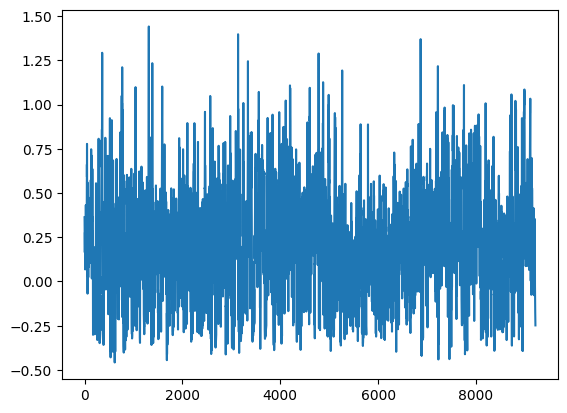

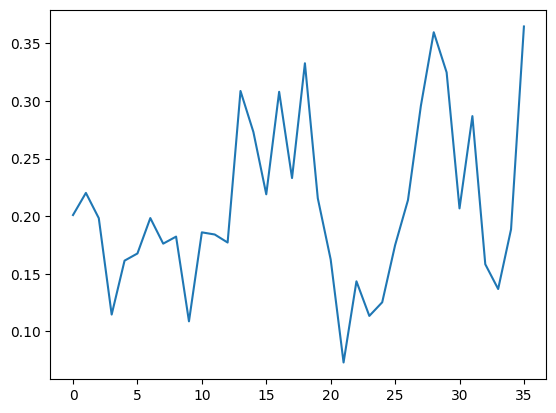

[PPO] Epoch 0: Loss=11.0064, Policy=0.0157, Value=22.0190
[PPO] Epoch 10: Loss=5.3922, Policy=0.0035, Value=10.8148
[PPO] Epoch 20: Loss=3.8272, Policy=-0.0096, Value=7.7115
[PPO] Epoch 30: Loss=3.2085, Policy=-0.0211, Value=6.4968
[PPO] Epoch 40: Loss=2.6497, Policy=-0.0228, Value=5.3819
Approx KL Learned: 0.05860663205385208
[✅] Actor-Critic checkpoint saved to clip_actor_critic_checkpoint_smooth_topk.pt
Update 10/10 — steps: 1024


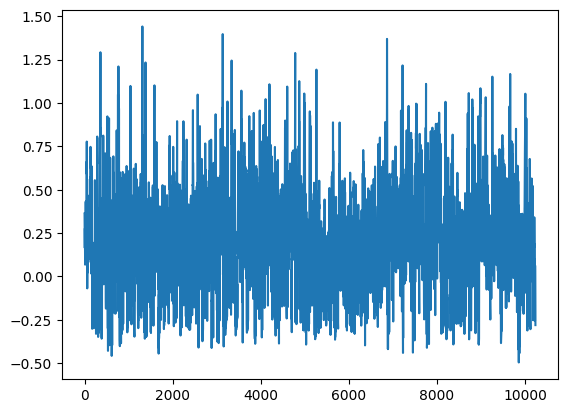

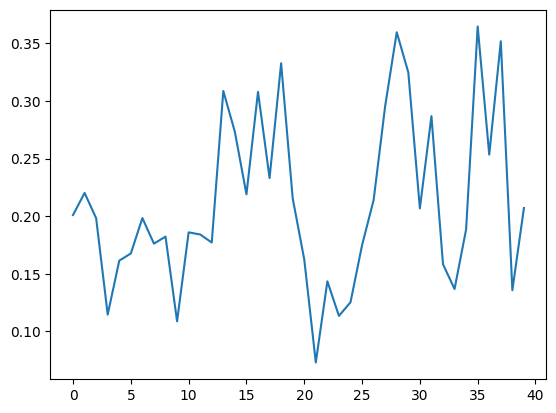

In [9]:
buf, rewards = train(controller, "clip_actor_critic_checkpoint_smooth_topk.pt", ppo, clip_env, clip_actor_critic, 10)

# CLIP Novelty - LSTM

In [ ]:
from models import LSTMActor, LSTMCritic

In [ ]:
ENTROPY_COEF = 0.0

ppo = PPO(ENTROPY_COEF)
encoder = FrozenResNetEncoder()
actor = LSTMActor(FEAT_DIM, NUM_ACTIONS)
critic = LSTMCritic(FEAT_DIM)
clip_novelty = CLIPNovelty()
clip_env = ClipEnv(clip_novelty)
clip_actor_critic = ActorCritic(encoder, actor, critic)
# buf, rewards = train(controller, ppo, clip_env, clip_actor_critic, 20)

In [ ]:
ENTROPY_COEF = 0.04
buf, rewards = train(controller, clip_env, clip_actor_critic, 20)

NameError: name 'train' is not defined

In [162]:
save_actor_critic(clip_actor_critic, "clip_actor_critic_checkpoint_clip_embed.pt")

[✅] Actor-Critic checkpoint saved to clip_actor_critic_checkpoint_clip_embed.pt


In [ ]:
house = dataset["train"][3]
controller = Controller(scene=house, snapToGrid=False, rotateStepDegrees=30)
event = controller.step("Pass")
spawn = event.metadata["agent"]["position"]

/home/juyuanli/miniconda3/envs/nav_assistant/lib/python3.11/site-packages/ai2thor/platform.py:154: UserWarning: could not connect to X Display: 5, Can't connect to display ":5": b'Authorization required, but no authorization protocol specified\n'
  warnings.warn(


In [14]:
from rl import load_actor_critic
load_actor_critic(clip_actor_critic, "data/clip_actor_critic_checkpoint_best_topk_20.pt", device=DEVICE)

[🔁] Actor-Critic checkpoint loaded from data/clip_actor_critic_checkpoint_best_topk_20.pt


Init position {'x': 5.171640396118164, 'y': 0.9009993672370911, 'z': 1.1309185028076172}


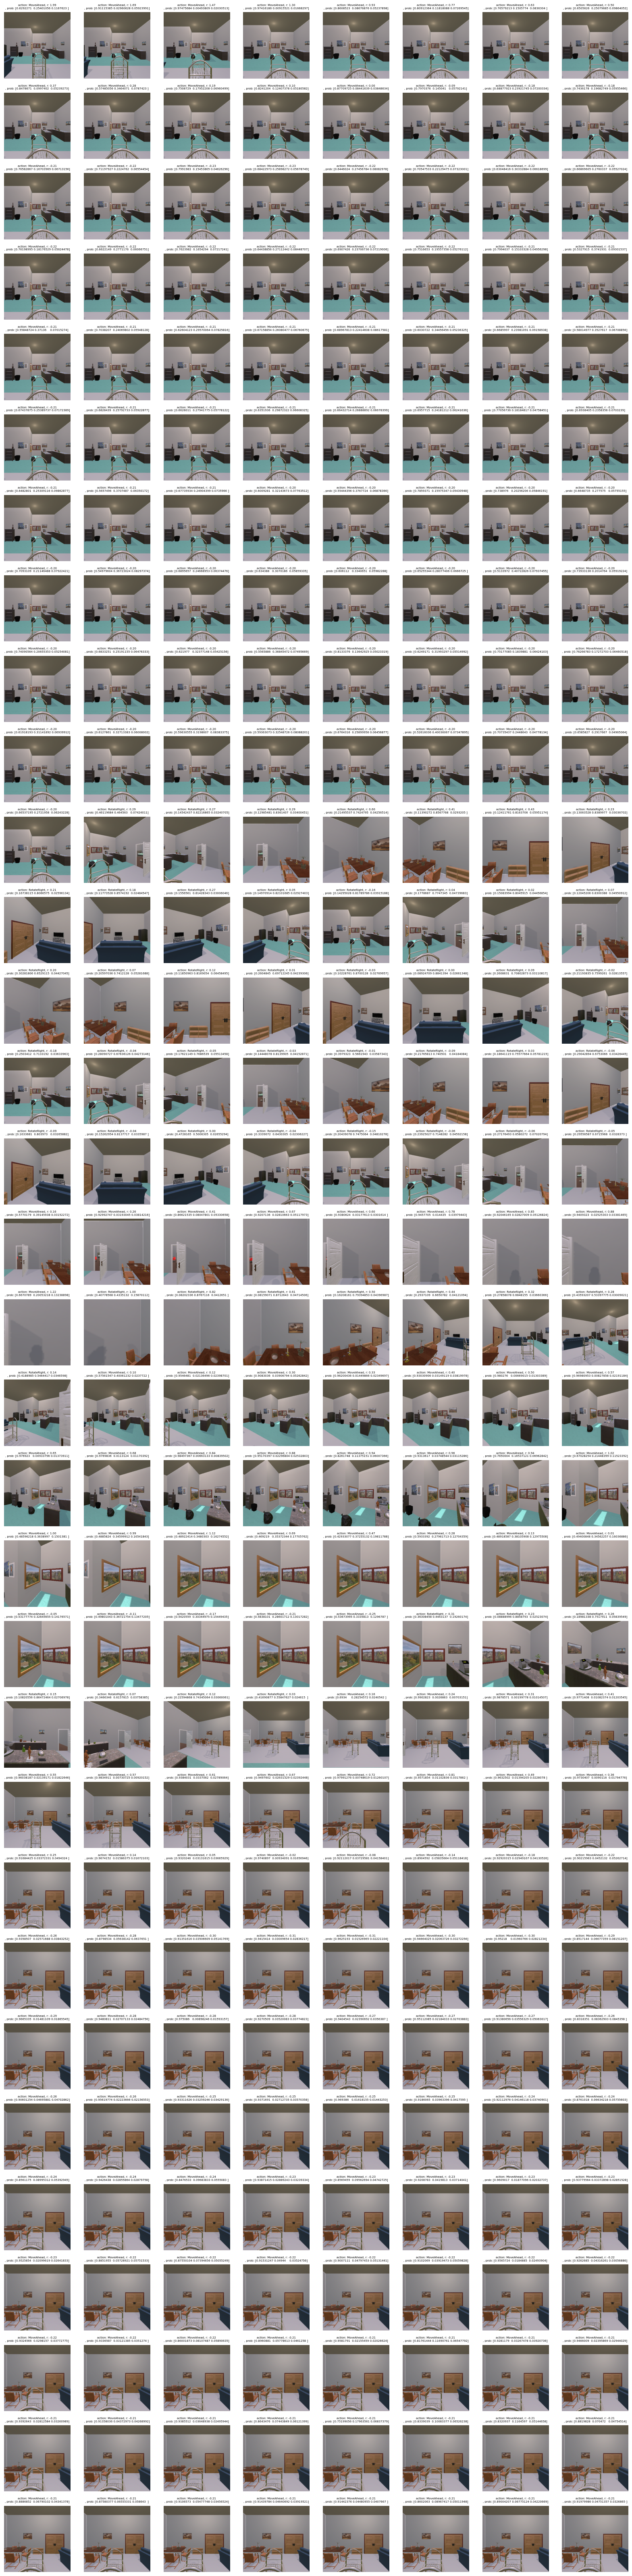

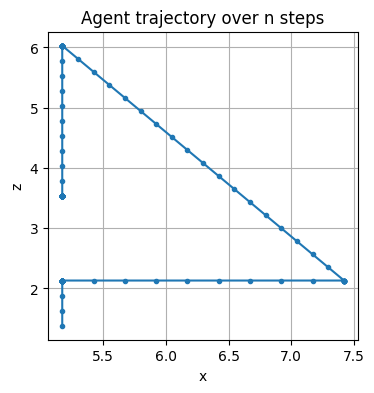

In [12]:
from cons import ACTIONS
from collections import deque
import matplotlib.pyplot as plt
import numpy as np

n = 256
n_row = 32
positions = []

plt.figure(figsize=(n // n_row * 2, n_row * 2))
# event = teleport(controller, {'x': 3.25, 'y': 0.9009997844696045, 'z': 5.0})
event = teleport(controller)
print("Init position", event.metadata["agent"]["position"])
episode_seq = deque(maxlen=EPISODE_STEPS)
actions_seq = deque(maxlen=EPISODE_STEPS)
for t in range(1, n + 1):
    obs_t = ppo.obs_from_event(event)  # (C,H,W)
    obs_seq = torch.stack(list(episode_seq) + [obs_t], dim=0).unsqueeze(0)
    
    if len(actions_seq) == 0:
        actions_seq.append(torch.randint(0, NUM_ACTIONS, (1, 1)).item())

    actions_tensor = torch.tensor(actions_seq, dtype=torch.long, device=DEVICE).unsqueeze(0)
    logits, value = ppo.act_and_value(obs_seq, actions_tensor, clip_actor_critic)
    dist = torch.distributions.Categorical(logits=logits)
    # dist = torch.distributions.Categorical(probs=torch.tensor([0.5,0.25,0.25]))
    action_idx = torch.argmax(logits)
    # action_idx = np.random.randint(0,4)

    event, reward = clip_env.step_env(controller, action_idx)
    done = t == EPISODE_STEPS

    # Extract agent position from metada
    # ta
    pos = event.metadata["agent"]["position"]
    positions.append((pos["x"], pos["z"]))  # store x,z
    episode_seq.append(obs_t)
    actions_seq.append(action_idx)

    # Plot frame and action
    plt.subplot(n_row, n // n_row, t)
    plt.title("action: " + ACTIONS[action_idx] + ", r: " + f"{reward:.2f}" + "\n, prob: " + str(torch.softmax(logits, dim=0).cpu().numpy()), fontsize=5)
    plt.axis(False)
    plt.imshow(event.frame)

plt.tight_layout()
plt.show()

# ---- Plot 2D trajectory of the agent ----
positions = np.array(positions)
plt.figure(figsize=(4, 4))
plt.plot(positions[:, 0], positions[:, 1], "-o", markersize=3)
plt.xlabel("x")
plt.ylabel("z")
plt.title("Agent trajectory over n steps")
plt.grid(True)
plt.show()


In [948]:
novelty.reset()

img_buffer = []

tensor([0.3384, 0.3403, 0.3716, 0.3354, 0.3110, 0.3008, 0.2163, 0.1621, 0.1206,
        0.0386, 0.0000, 0.2642, 0.3384, 0.3403, 0.3716, 0.3354, 0.3110, 0.3008,
        0.2163, 0.1621, 0.1206, 0.0386, 0.0000, 0.2642, 0.3384, 0.3403, 0.3716,
        0.3354, 0.3110, 0.3008, 0.2163, 0.1621, 0.1206, 0.0386, 0.0000, 0.2642,
        0.3384, 0.3403, 0.3716, 0.3354, 0.3110, 0.3008, 0.2163, 0.1621, 0.1206,
        0.0386, 0.0000, 0.2642, 0.3384, 0.3403, 0.3716, 0.3354, 0.3110, 0.3008,
        0.2163, 0.1621, 0.1206, 0.0386, 0.0000, 0.2642, 0.3384, 0.3403, 0.3716,
        0.3354, 0.3110, 0.3008, 0.2163, 0.1621, 0.1206, 0.0386, 0.0000, 0.2642,
        0.3384, 0.3403, 0.3716, 0.3354, 0.3110, 0.3008, 0.2163, 0.1621, 0.1206,
        0.0386, 0.0000, 0.2642, 0.3384, 0.3403, 0.3716, 0.3354, 0.3110, 0.3008,
        0.2163, 0.1621, 0.2163, 0.3008, 0.2163, 0.1621, 0.1206, 0.0386, 0.1206,
        0.1621, 0.2163, 0.3008, 0.2163, 0.1621, 0.1206, 0.0386, 0.0000, 0.2642,
        0.3384, 0.2642], device='cuda:0'

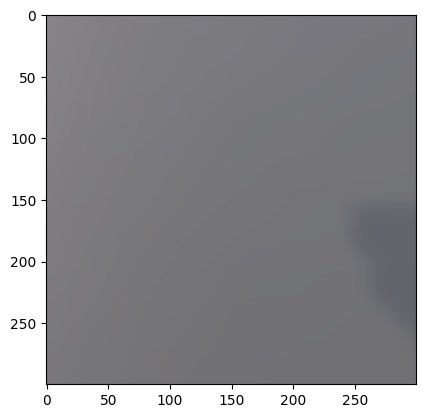

In [1075]:
# teleport(controller, {'x': 8.790684700012207, 'y': 0.9009993672370911, 'z': 2.460493564605713})

action_idx = 2
event = controller.step("RotateRight")

plt.imshow(event.frame)

novelty = clip_env.clip_novelty


frame_np = event.frame
# action_idx = np.random.randint(0,4)
img = Image.fromarray(frame_np)
img_t = novelty.preprocess(img).unsqueeze(0).to(novelty.device)
emb = novelty.model.encode_image(img_t)
emb = emb / emb.norm(dim=-1, keepdim=True)  # normalize to unit sphere
if len(novelty.buffer) == 0:
    novelty.buffer.append(emb)
    img_buffer.append(event.frame)
else:
#     return 0.0  # no past frames to compare yet
    past = torch.cat(list(novelty.buffer), dim=0)  # (N, D)
    sim = F.cosine_similarity(emb, past)        # (N,)
    print((1 - sim), 10 * torch.clamp(sim - 0.98, min=0.0)**2)
    reward = torch.mean((1 - sim) - 10 * torch.clamp(sim - 0.98, min=0.0)**2)
    novelty.buffer.append(emb)
    img_buffer.append(event.frame)
    print(sim)
    print(reward)

In [ ]:
Wall vs wall 0.9614


(<matplotlib.collections.PathCollection at 0x7fe3d001b550>,
 tensor(0.0137, device='cuda:0', dtype=torch.float16, grad_fn=<VarBackward0>),
 tensor(0.7705, device='cuda:0', dtype=torch.float16, grad_fn=<MeanBackward0>))

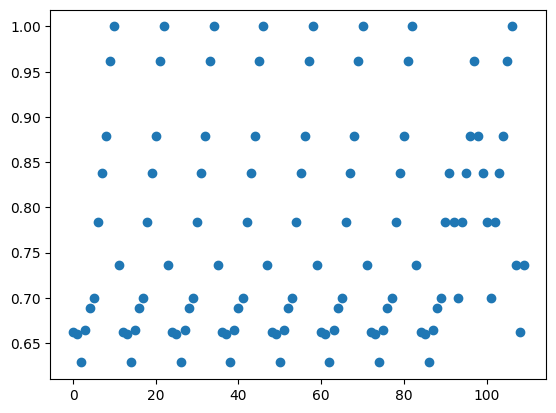

In [1076]:
plt.scatter(np.arange(len(sim)), sim.detach().cpu()), sim.var(), sim.mean()

(<matplotlib.collections.PathCollection at 0x7fe5487c1490>,
 tensor(0.0191, device='cuda:0', dtype=torch.float16, grad_fn=<VarBackward0>),
 tensor(0.7900, device='cuda:0', dtype=torch.float16, grad_fn=<MeanBackward0>))

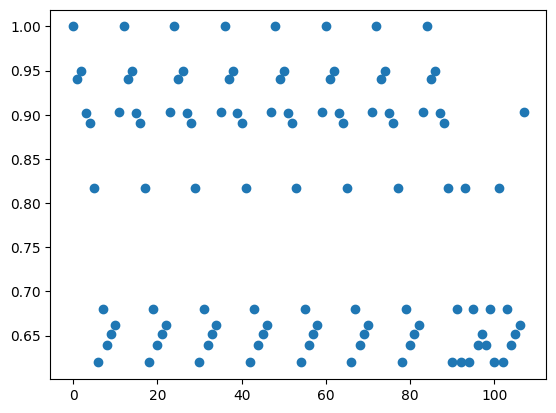

In [1073]:
plt.scatter(np.arange(len(sim)), sim.detach().cpu()), sim.var(), sim.mean()

In [ ]:
controller.stop()